# TF-IDF version

This notebook are design for TF-IDF version. For experiment and performanance consideration, original dataset are resampled into a smaller dataset.

## Import necessary package

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [2]:
# NLTK
import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('names')


# Tokeenization
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.corpus import wordnet
from nltk import pos_tag, pos_tag_sents
from nltk.stem import WordNetLemmatizer

# Vectorizer
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Utilities
from collections import OrderedDict
import pickle
from tqdm import tqdm
import operator 

# Plotting
from matplotlib import pyplot as plt

# Classifier
from sklearn.naive_bayes import MultinomialNB

# Word Embedding
from gensim.models.keyedvectors import KeyedVectors

# Spell check
from spellchecker import SpellChecker

import re
import gc

# Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from gensim.matutils import unitvec

import logging
import normalise



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\derekhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


D:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
tqdm.pandas("Progress")

## Load and resampling dataset

In [5]:
training_dataset = pd.read_csv("../input/train.csv")
testing_dataset = pd.read_csv("../input/test.csv")

In [6]:
training_dataset_tiny = training_dataset.sample(frac=0.01, random_state=42)
training_dataset_small = training_dataset.sample(frac=0.1, random_state=42)

## Prepare TF-IDF vectorizer

In [7]:
stopwords_en = set(stopwords.words('english'))
stopwords_en_withpunct = stopwords_en.union(set(punctuation))
#stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
#stopwords_combined = set.union(set(stopwords_json['en']), stopwords_en_withpunct)
stopwords = stopwords_en_withpunct

In [8]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(text_to_word_sequence(text))]

In [191]:
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    tokens =  [word for word in lemmatize_sent(text) 
            if word not in stopwords
            and not word.isdigit()]
    tokens = normalise.normalise(text=tokens, user_abbrevs=custom_dictionary, verbose=False)
   
    
    return tokens;

In [10]:
class CustomVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stop_words = self.get_stop_words()
    
        def analyser(doc):
            if (self.lowercase == True):
                doc = doc.lower()
            tokens = preprocess_text(doc)
            
            return(self._word_ngrams(tokens, stop_words))
        return (analyser)

## Initialize TF-IDF vectorizer

In [11]:
max_features_TFIDF = 1000
ngram_range_TFIDF = (1, 1)

In [12]:
tfidf_vectorizer = CustomVectorizer(stop_words=stopwords,
                                    ngram_range=ngram_range_TFIDF,
                                    max_features=max_features_TFIDF,
                                    encoding='utf-8',
                                    decode_error='strict',
                                    strip_accents = None,
                                    lowercase=True)

## Train TF-IDF feature vectors

In [16]:
tfidf_vectors_tiny = tfidf_vectorizer.fit_transform(training_dataset_tiny['question_text'])

## Review TF-IDF feature vectors

In [17]:
terms = tfidf_vectorizer.get_feature_names()
sums = tfidf_vectors_tiny.sum(axis=0)

word_info = []
for col, term in enumerate(terms):
    word_info.append( (term, sums[0,col] ))

ranking = pd.DataFrame(word_info, columns=['term','rank'])
keywords = ranking.sort_values('rank', ascending=False)

In [18]:
keywords.head(20)

,term,rank
390,get,250.198821
117,best,228.659602
3,'s,213.781729
946,use,195.286116
986,would,194.455274
651,people,190.666262
397,good,189.814823
519,like,181.068262
539,make,176.219783
454,india,133.550014


## Preprocess text

Due to the result of TF-IDF vectorizer contains some meaningless terms such as "'s'", "n't" and part of them can be restored to their original form, we need to preprocess the original text.

In [158]:
custom_dictionary = { "won't": 'will not',  
                      "what's": 'what is'
                    }

### TF-IDF (normalized)

In [207]:
stopwords = stopwords.union(set(['']))

In [13]:

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    
    tokens =  [word for word in lemmatize_sent(text) 
            if word not in stopwords
            and not word.isdigit()]
    try: 
        tokens = normalise.normalise(text=tokens, user_abbrevs=custom_dictionary, verbose=False)
    except:
        result = []
        for text in tokens:
            try:
                result.append(normalise.normalise(texts, verbose=False))
            except:
                result.append(text)
        tokens = result
    tokens = [word for word in tokens
          if word not in stopwords]
    return tokens;

## Train TF-IDF feature vectors

In [193]:
class CustomVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stop_words = self.get_stop_words()
    
        def analyser(doc):
            if (self.lowercase == True):
                doc = doc.lower()
            tokens = preprocess_text(doc)
            
            return(self._word_ngrams(tokens, stop_words))
        return (analyser)

In [15]:
tfidf_vectorizer_preprocessing = CustomVectorizer(stop_words=stopwords,
                                    ngram_range=ngram_range_TFIDF,
                                    max_features=max_features_TFIDF,
                                    encoding='utf-8',
                                    decode_error='strict',
                                    strip_accents = None,
                                    lowercase=True)

In [208]:
tfidf_vectors_tiny_preprocessing = tfidf_vectorizer_preprocessing.fit_transform(training_dataset_tiny['question_text'])

In [209]:
terms = tfidf_vectorizer_preprocessing.get_feature_names()
sums = tfidf_vectors_tiny_preprocessing.sum(axis=0)

word_info = []
for col, term in enumerate(terms):
    word_info.append( (term, sums[0,col] ))

ranking = pd.DataFrame(word_info, columns=['term','rank'])
keywords = ranking.sort_values('rank', ascending=False)

In [211]:
keywords

,term,rank
384,get,260.012017
106,best,225.979241
947,use,203.734527
990,would,193.232869
653,people,187.652073
392,good,187.447267
518,like,184.340280
539,make,177.489796
454,india,131.842838
491,know,119.230941


### Visualize

In [216]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
tfidf_vectors_tiny_preprocessing_svd = svd.fit_transform(X=tfidf_vectors_tiny_preprocessing)

In [222]:
df_tfidf_vectors_tiny_preprocessing_svd = pd.DataFrame(tfidf_vectors_tiny_preprocessing_svd)

In [223]:
df_tfidf_vectors_tiny_preprocessing_svd['target'] = training_dataset_tiny['target'].values

In [235]:
df_tfidf_vectors_tiny_preprocessing_svd[df_tfidf_vectors_tiny_preprocessing_svd['target'] == 0][0]

0        0.071309
1        0.042300
2        0.154622
3        0.035460
4        0.078361
5        0.014485
6        0.006350
7        0.187351
8        0.039864
9        0.048866
10       0.036474
11       0.007866
12       0.162376
13       0.063860
14       0.000000
15       0.046308
16       0.095813
17       0.012549
18       0.031626
19       0.012405
20       0.055805
21       0.114282
22       0.123356
23       0.047654
24       0.000000
25       0.034628
26       0.000000
27       0.034757
28       0.165780
29       0.277131
           ...   
13027    0.115830
13028    0.041753
13029    0.023152
13030    0.083407
13031    0.032427
13032    0.172420
13033    0.140473
13034    0.040145
13035    0.024546
13036    0.018229
13037    0.118853
13038    0.014492
13039    0.019053
13040    0.025547
13041    0.121225
13043    0.117825
13044    0.106875
13045    0.326132
13046    0.081154
13047    0.036418
13048    0.125254
13049    0.031861
13050    0.077755
13052    0.190872
13053    0

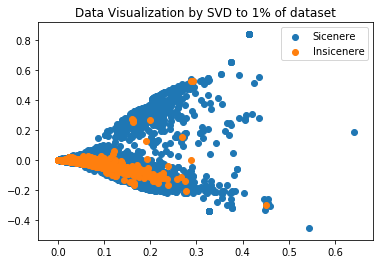

In [241]:
plt.scatter(x=df_tfidf_vectors_tiny_preprocessing_svd[df_tfidf_vectors_tiny_preprocessing_svd['target'] == 0][0], y=df_tfidf_vectors_tiny_preprocessing_svd[df_tfidf_vectors_tiny_preprocessing_svd['target'] == 0][1])
plt.scatter(x=df_tfidf_vectors_tiny_preprocessing_svd[df_tfidf_vectors_tiny_preprocessing_svd['target'] == 1][0], y=df_tfidf_vectors_tiny_preprocessing_svd[df_tfidf_vectors_tiny_preprocessing_svd['target'] == 1][1])
plt.legend(['Sicenere', 'Insicenere'])
plt.title("Data Visualization by SVD to 1% of dataset")
plt.savefig("Data_Visualization_by_SVD_to_1%_of_dataset")

## Naive Bayes

In [12]:
train_small, test_small = train_test_split(training_dataset_small, test_size=0.2, random_state=42)

In [20]:
train_small_vectors = tfidf_vectorizer_preprocessing.fit_transform(train_small['question_text'])

In [21]:
terms = tfidf_vectorizer_preprocessing.get_feature_names()
sums = train_small_vectors.sum(axis=0)

word_info = []
for col, term in enumerate(terms):
    word_info.append( (term, sums[0,col] ))

ranking = pd.DataFrame(word_info, columns=['term','rank'])
keywords = ranking.sort_values('rank', ascending=False)

In [22]:
keywords.head(20)

,term,rank
377,get,2083.868798
90,best,1948.348078
658,people,1547.257325
385,good,1506.621599
990,would,1503.729631
946,use,1455.662114
534,make,1449.159249
512,like,1441.696606
444,india,1038.279183
634,one,977.477287


In [23]:
test_small_vectors = tfidf_vectorizer_preprocessing.transform(test_small['question_text'])

In [26]:
gnb = GaussianNB()
gnb.fit(train_small_vectors.toarray(), train_small['target'])
y_pred = gnb.predict(test_small_vectors.toarray())

In [27]:
print("Accuracy score: %f"%accuracy_score(y_true=test_small['target'], y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=test_small['target'], y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=test_small['target'], y_pred=y_pred))

Accuracy score: 0.534510
Recall score: 0.898196
F1 score: 0.186513


## Naive Bayes (2 gram)

In [28]:
tfidf_vectorizer_preprocessing_2gram = CustomVectorizer(stop_words=stopwords,
                                    ngram_range=(2, 2),
                                    max_features=max_features_TFIDF,
                                    encoding='utf-8',
                                    decode_error='strict',
                                    strip_accents = None,
                                    lowercase=True)

In [29]:
train_small_vectors_2gram = tfidf_vectorizer_preprocessing_2gram.fit_transform(train_small['question_text'])

In [30]:
test_small_vectors_2gram = tfidf_vectorizer_preprocessing_2gram.transform(test_small['question_text'])

In [31]:
terms = tfidf_vectorizer_preprocessing_2gram.get_feature_names()
sums = train_small_vectors_2gram.sum(axis=0)

word_info = []
for col, term in enumerate(terms):
    word_info.append( (term, sums[0,col] ))

ranking = pd.DataFrame(word_info, columns=['term','rank'])
keywords = ranking.sort_values('rank', ascending=False)

In [33]:
keywords.head(20)

,term,rank
84,best way,506.941715
992,year old,367.787437
963,would happen,311.478065
877,united state,259.358930
469,look like,231.775195
190,donald trump,204.689129
246,feel like,179.263745
308,get rid,178.903574
376,high school,172.610831
297,get job,163.122182


In [35]:
gnb = GaussianNB()
gnb.fit(train_small_vectors_2gram.toarray(), train_small['target'])
y_pred = gnb.predict(test_small_vectors_2gram.toarray())

In [36]:
print("Accuracy score: %f"%accuracy_score(y_true=test_small['target'], y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=test_small['target'], y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=test_small['target'], y_pred=y_pred))

Accuracy score: 0.169391
Recall score: 0.969072
F1 score: 0.121752


## Naive Bayes (1 and 2 grams)

In [39]:
tfidf_vectorizer_preprocessing_12gram = CustomVectorizer(stop_words=stopwords,
                                    ngram_range=(1, 2),
                                    max_features=max_features_TFIDF,
                                    encoding='utf-8',
                                    decode_error='strict',
                                    strip_accents = None,
                                    lowercase=True)

In [40]:
train_small_vectors_12gram = tfidf_vectorizer_preprocessing_12gram.fit_transform(train_small['question_text'])
test_small_vectors_12gram = tfidf_vectorizer_preprocessing_12gram.transform(test_small['question_text'])

In [44]:
terms = tfidf_vectorizer_preprocessing_12gram.get_feature_names()
sums = train_small_vectors_12gram.sum(axis=0)

word_info = []
for col, term in enumerate(terms):
    word_info.append( (term, sums[0,col] ))

ranking = pd.DataFrame(word_info, columns=['term','rank'])
keywords = ranking.sort_values('rank', ascending=False)

In [45]:
keywords.head(20)

,term,rank
375,get,2053.384556
89,best,1889.596268
659,people,1531.067002
385,good,1508.959818
986,would,1467.945171
940,use,1459.891000
534,make,1451.518237
511,like,1410.105457
444,india,1037.963893
635,one,977.714246


In [48]:
gnb = GaussianNB()
gnb.fit(train_small_vectors_12gram.toarray(), train_small['target'])
y_pred = gnb.predict(test_small_vectors_12gram.toarray())

In [49]:
print("Accuracy score: %f"%accuracy_score(y_true=test_small['target'], y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=test_small['target'], y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=test_small['target'], y_pred=y_pred))

Accuracy score: 0.527351
Recall score: 0.900129
F1 score: 0.184532


## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

randomForestClassifier = RandomForestClassifier(n_estimators=30, 
                       max_depth=120,
                       min_samples_leaf=2,
                       max_features="auto",
                       n_jobs=-1)

randomForestClassifier.fit(train_small_vectors, train_small['target'])
y_pred = randomForestClassifier.predict(test_small_vectors)


In [78]:
print("Accuracy score: %f"%accuracy_score(y_true=test_small['target'], y_pred=y_pred))
print("Recall score: %f"%recall_score(y_true=test_small['target'], y_pred=y_pred))
print("F1 score: %f"%f1_score(y_true=test_small['target'], y_pred=y_pred))

Accuracy score: 0.944225
Recall score: 0.152706
F1 score: 0.245469


## Playground

In [112]:
text = training_dataset.iloc[10]['question_text']
print(text)
print(clean_text(text))
normalise.normalise(clean_text(text), tokenizer=word_tokenize, verbose=False)

What can you say about feminism?
What can you say about feminism


['What', 'can', 'you', 'say', 'about', 'feminism']

In [185]:
normalise.normalise(clean_text("Preprocessing is the most important step"), tokenizer=text_to_word_sequence, verbose=False)

['preprocessing', 'is', 'the', 'most', 'important', 'step']

In [189]:
index = 0
for text in tqdm(training_dataset['question_text'].iloc[:100], disable=('verbose')):
    print(text + "/" + str(training_dataset['target'].iloc[index]))
    print(preprocess_text(text))
    index = index+1

How did Quebec nationalists see their province as a nation in the 1960s?/0
['quebec', 'nationalist', 'see', 'province', 'nation', 'nineteen sixties']
Do you have an adopted dog, how would you encourage people to adopt and not shop?/0
['adopt', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop']
Why does velocity affect time? Does velocity affect space geometry?/0
['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry']
How did Otto von Guericke used the Magdeburg hemispheres?/0
['otto', 'von', 'guericke', 'use', 'magdeburg', 'hemisphere']
Can I convert montra helicon D to a mountain bike by just changing the tyres?/0
['convert', 'months', 'helicon', 'mountain', 'bike', 'change', 'tyre']
Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?/0
['gaze', 'slowly', 'become', 'auschwitz', 'dachau', 'treblinka', 'palestinian']
Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?/0
['quota', 'a

In [179]:
lemmatize_sent("Ryan's book")

['ryan', "'s", 'book']

In [178]:
word_tokenize("Ryan's book")

['Ryan', "'s", 'book']

In [190]:
text_to_word_sequence('is old english "pure english"?')

['is', 'old', 'english', 'pure', 'english']

In [184]:
normalise.normalise(text_to_word_sequence("Who's your daddy"))


CREATING NSW DICTIONARY
-----------------------

0 NSWs found

TAGGING NSWs
------------

0 of 0 tagged

SPLITTING NSWs
--------------

0 of 0 split

RETAGGING SPLIT NSWs
--------------------

0 of 0 retagged

CLASSIFYING ALPHABETIC NSWs
---------------------------

0 of 0 classified

CLASSIFYING NUMERIC NSWs
------------------------

0 of 0 classified

CLASSIFYING MISCELLANEOUS NSWs
------------------------------

0 of 0 classified

EXPANDING ALPHABETIC NSWs
-------------------------

0 of 0 expanded

EXPANDING NUMERIC NSWs
----------------------

0 of 0 expanded

EXPANDING MISCELLANEOUS NSWs
----------------------------

0 of 0 expanded



["who's", 'your', 'daddy']

In [177]:
normalise.normalise("Ryan's book", user_abbrevs=custom_dictionary, verbose=False)

["Ryan's", 'book']

In [162]:
stopwords

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [137]:
texts = ['reaction', 'nahso4+nacl=na2so4+hcl']

try: 
    normalise.normalise(texts, verbose=False)
except:
    result = []
    for text in texts:
        try:
            result.append(normalise.normalise(texts, verbose=False))
        except:
            result.append(text)
print(result)            

['reaction', 'nahso4+nacl=na2so4+hcl']


In [176]:
my_abbreviations = {"bdrm": "bedroom",
                    "KT": "kitchen",
                    "wndw": "window",
                    "ONO": "or near offer"}

text = ["4bdrm", "house", "for", "sale", ",", "£459k", "ONO"]

normalise.normalise(text, user_abbrevs={"ONO": "or near offer"})


CREATING NSW DICTIONARY
-----------------------

3 NSWs found

TAGGING NSWs
------------

3 of 3 tagged

SPLITTING NSWs
--------------

1 of 1 split

RETAGGING SPLIT NSWs
--------------------

2 of 2 retagged

CLASSIFYING ALPHABETIC NSWs
---------------------------

2 of 2 classified

CLASSIFYING NUMERIC NSWs
------------------------

2 of 2 classified

CLASSIFYING MISCELLANEOUS NSWs
------------------------------

0 of 0 classified

EXPANDING ALPHABETIC NSWs
-------------------------

2 of 2 expanded

EXPANDING NUMERIC NSWs
----------------------

2 of 2 expanded

EXPANDING MISCELLANEOUS NSWs
----------------------------

0 of 0 expanded



['four form',
 'house',
 'for',
 'sale',
 ',',
 'four hundred and fifty nine thousand pounds',
 'ONO']

In [256]:
words = lemmatize_sent("how are dangerous are spaag vehicles such as the zsu-23-4 against helicopters and drones?")

In [260]:
print(words)

['how', 'be', 'dangerous', 'be', 'spaag', 'vehicle', 'such', 'a', 'the', 'zsu', '23', '4', 'against', 'helicopter', 'and', 'drone']


In [261]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\derekhsu\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [258]:
for word in words:
    print(word)
    print(word in stopwords)

how


TypeError: argument of type 'WordListCorpusReader' is not iterable